In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Custom code
from coordination.common.sparse_series import SparseSeries
from coordination.inference.vocalics import DiscreteCoordinationInferenceFromVocalics
from coordination.plot.coordination import plot_discrete_coordination, add_discrete_coordination_bar
from coordination.plot.vocalics import plot_vocalic_features
from coordination.synthetic.coordination_generator import DiscreteCoordinationGenerator
from coordination.synthetic.vocalics_generator import VocalicsGeneratorForDiscreteCoordination

# Model Definition

We start with coordination as a binary variable. Vocalic series for subjects A and B are observed at different time scales. A single value of this series at a time step $t$ contains the average value of vocalic features whithin an utterance that ended at time $t$. If no utterance ended at that time, there's no link between the coordination variable and the vocalic series. That means the model structure is defined according to the data. 

The existance of coordination affects the coupling between series $A$ and $B$, that is, whether $B_t$ depends on $A_{t-1}$ and vice versa or just in the previous value of it's own series. This reflects the idea that ff two people are coordinated, we should be able to predict the next value of B from the current value of A (and vice versa).

The distributions are as follows:

$
\begin{align}
p(C_0) &= \text{Bernoulli}(C_0; p\_coordination) \\
p(C_t | C_{t-1}) &=
\begin{cases}
\text{Bernoulli}(C_t; 1 - p\_coordination\_transition),~\text{if}~C_t = C_{t-1} \\
\text{Bernoulli}(C_t; p\_coordination\_transition),~\text{otherwise}
\end{cases}\\
p(\text{Feature}_A) = p(\text{Feature}_B) &\sim \mathcal{N}(\text{Feature}; 0, I) ~~\text{(prior)}\\
p(A_{t}|A_{t-1}, B_{t-1}, C_t) &= \mathcal{N}(A_{t};f(A_{t-1}), \sigma_{uncoord_A})^{1-C_t}\mathcal{N}(A_{t};f(B_{t-1}), \sigma_{coord_A})^{C_t} \\
p(B_{t}|B_{t-1}, A_{t-1}, C_t) &= \mathcal{N}(B_{t};f(B_{t-1}), \sigma_{uncoord_B})^{1-C_t}\mathcal{N}(B_{t};f(A_{t-1}), \sigma_{coord_B})^{C_t} \\
\end{align}
$

This model makes a series of assumptions:

1. Coordination is a discrete value (either it exists or not)
2. There's a $p\_coordination\_transition$ chance of change in the coordination from one time step to the next 
3. We start by setting $f(.)$ to be the identity function. That means coordination is observed as a simple linear coupling betweeen the series.

In [30]:
# Constants
SEED = 0 # For reproducibility
OBSERVATION_DENSITY = 1 # Proportion of timesteps with observation
NUM_TIME_STEPS = 100
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant for now
NUM_FEATURES = 2

# Parameters of the distributions
P_COORDINATION_TRANSITION = 0.1 # Coordination changes with small probability
P_COORDINATION = 0 # The process starts with no coordination
MEAN_PRIOR_A = np.zeros(NUM_FEATURES)
MEAN_PRIOR_B = np.zeros(NUM_FEATURES)
STD_PRIOR_A = np.ones(NUM_FEATURES)
STD_PRIOR_B = np.ones(NUM_FEATURES)
STD_UNCOORDINATED_A = np.ones(NUM_FEATURES)
STD_UNCOORDINATED_B = np.ones(NUM_FEATURES)
STD_COORDINATED_A = np.ones(NUM_FEATURES)
STD_COORDINATED_B = np.ones(NUM_FEATURES)

## Syntetic Data

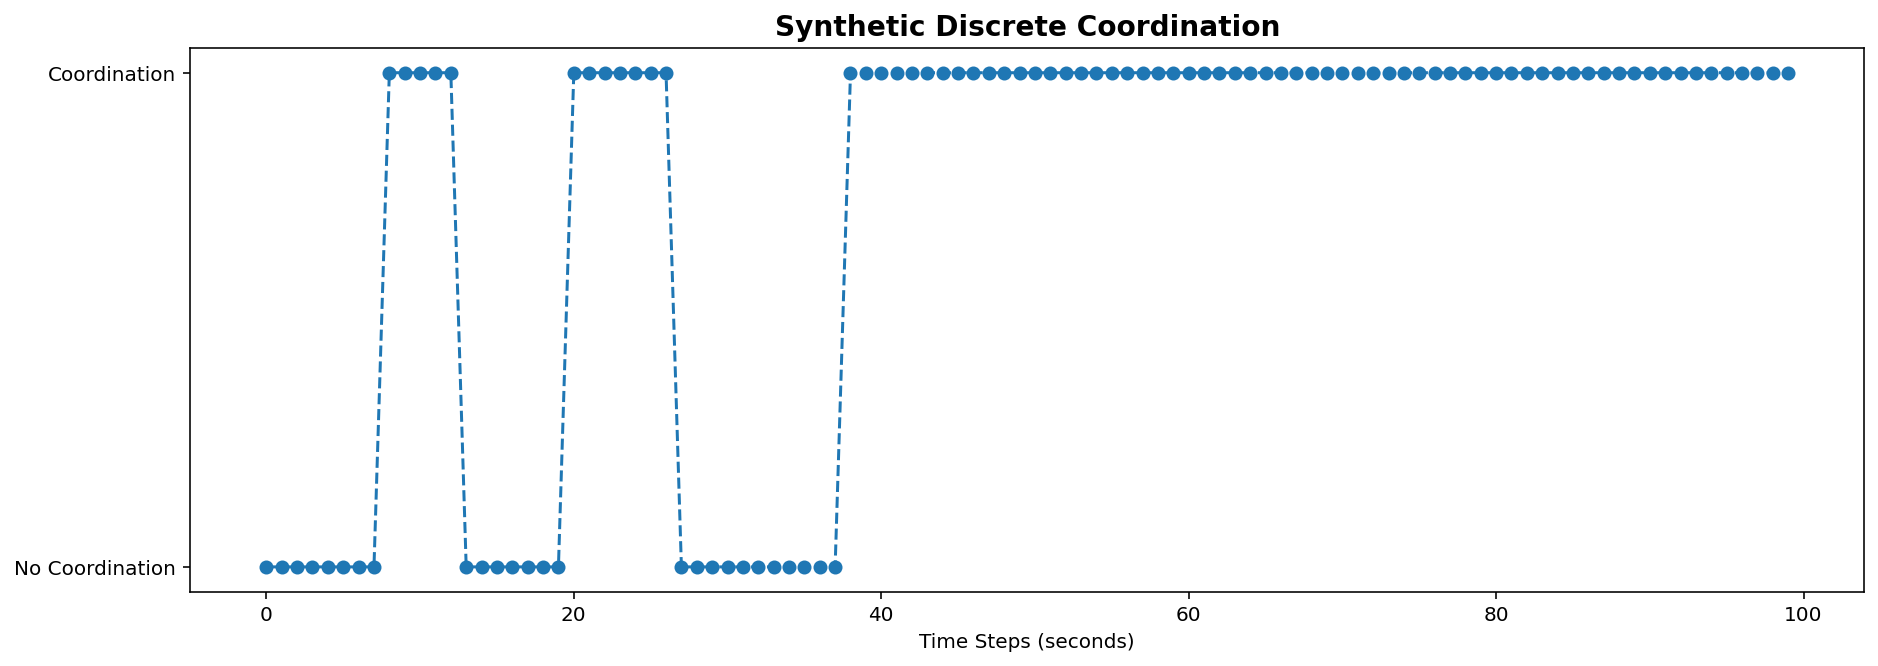

In [4]:
generator = DiscreteCoordinationGenerator(num_time_steps=NUM_TIME_STEPS, 
                                          p_coordinated=P_COORDINATION, 
                                          p_transition=P_COORDINATION_TRANSITION)
discrete_cs = generator.generate(SEED)
discrete_cs[M:] = discrete_cs[M]

fig = plt.figure(figsize=(15,5))
plot_discrete_coordination(ax=fig.gca(), 
                           coordination=discrete_cs, 
                           color="tab:blue", 
                           title="Synthetic Discrete Coordination",
                           xaxis_label="Time Steps (seconds)")

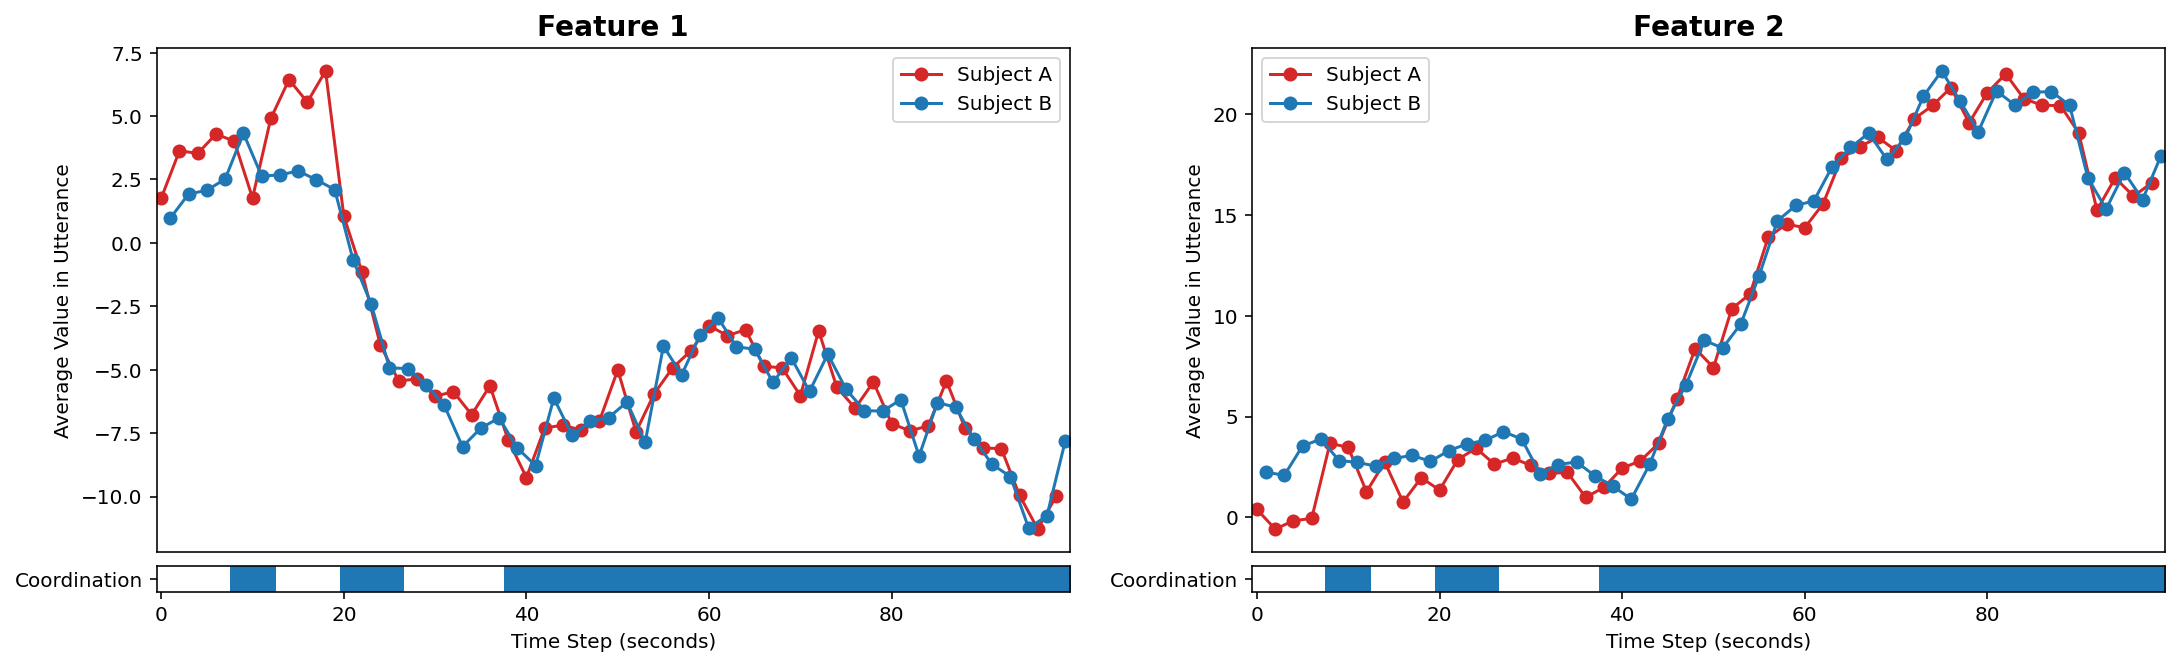

In [5]:
generator = VocalicsGeneratorForDiscreteCoordination(coordination_series=discrete_cs,
                                                     num_vocalic_features=NUM_FEATURES,
                                                     time_scale_density=OBSERVATION_DENSITY,
                                                     mean_prior_a=MEAN_PRIOR_A,
                                                     mean_prior_b=MEAN_PRIOR_B,
                                                     std_prior_a=STD_PRIOR_A,
                                                     std_prior_b=STD_PRIOR_B,
                                                     std_uncoordinated_a=STD_UNCOORDINATED_A,
                                                     std_uncoordinated_b=STD_UNCOORDINATED_B,
                                                     std_coordinated_a=STD_COORDINATED_A,
                                                     std_coordinated_b=STD_COORDINATED_B)
vocalics_a, vocalics_b = generator.generate(SEED)

fig, axs = plt.subplots(1, 2, figsize=(18,5))
plot_vocalic_features(axs, vocalics_a, vocalics_b, ["Feature 1", "Feature 2"], False)
add_discrete_coordination_bar(main_ax=axs[0],
                             coordination_series=[discrete_cs],
                             coordination_colors=["tab:blue"],
                             labels=["Coordination"])
add_discrete_coordination_bar(main_ax=axs[1],
                             coordination_series=[discrete_cs],
                             coordination_colors=["tab:blue"],
                             labels=["Coordination"])

## Inference

Based on the observed vocalic series component, we can infer the coordination at each time step. The joint distribution of coordination and vocalics components is

$
\begin{align}
p(C_{0:T}, A_{0:T}, B_{0:T}, f) = p(C_0)\prod^{T}_{t=1}p(C_t|C_{t-1})p(A_t|A_{t-1}, B_{t-1}, C_t, f)p(B_t|B_{t-1},A_{t-1},C_t, f)
\end{align}
$

Notice that for a certain $t$, $A_t$ and $B_t$ might not have been observed, which means we do not include their terms in the equation above, or they are replaced by 1 which has the same effect. Also, $B_{t-1}$ and $A_{t-1}$ refer to the last time values for the series were observed, thus that might not correspond to the actual $t-1$ time step. 

Inference here can be performed exactly using message passing because of the discrete nature of coordination.

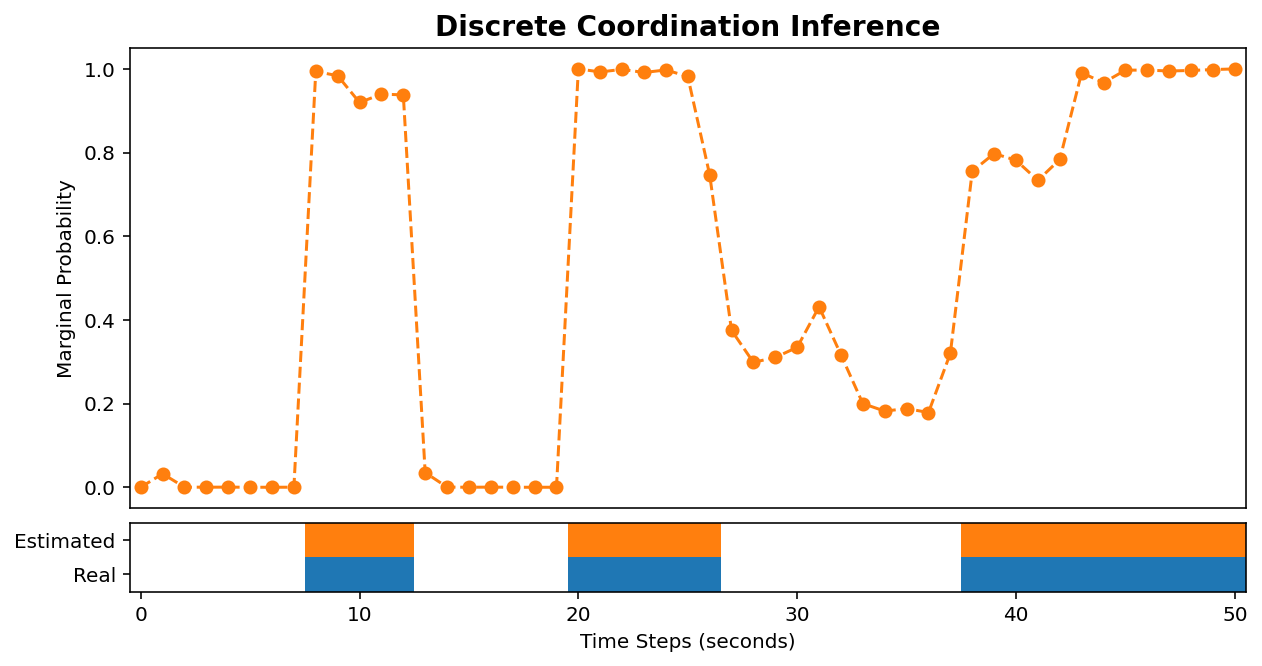

In [6]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(series_a=vocalics_a, 
                                                             series_b=vocalics_b, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION, 
                                                             mean_prior_a=MEAN_PRIOR_A,
                                                             mean_prior_b=MEAN_PRIOR_B,
                                                             std_prior_a=STD_PRIOR_A,
                                                             std_prior_b=STD_PRIOR_B,
                                                             std_uncoordinated_a=STD_UNCOORDINATED_A,
                                                             std_uncoordinated_b=STD_UNCOORDINATED_B,
                                                             std_coordinated_a=STD_COORDINATED_A,
                                                             std_coordinated_b=STD_COORDINATED_B)
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(10, 5))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[discrete_cs[:M+1], np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:blue", "tab:orange"],
                              labels=["Real", "Estimated"])